plot the examples of post-processing time series data

In [1]:
import numpy as np
import os
from os.path import join
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
from pyproj import Proj, CRS, Transformer
import pysptools
import pysptools.abundance_maps


def get_row_col_id_from_lat_long(latitude, longitude):
    """get the row and col in from the latitude and longitude

    Args:
        latitude (_type_): _description_
        longitude (_type_): _description_

    Returns:
        _type_: _description_
    """
    proj_wgs84 = CRS("WGS84")
    src_proj = ('PROJCS["Albers_Conic_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",'
                'SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],'
                'AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],'
                'PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],'
                'PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],'
                'UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

    src_geotrans = (2333008.6177587425, 30.0, 0.0, 39144.35085645504, 0.0, -30.0)

    transformer = Transformer.from_proj(proj_wgs84, src_proj)
    x, y = transformer.transform(latitude, longitude)

    res = 30
    NRow, NCol = 2500, 2500

    col_id_study_area = int(abs((x - src_geotrans[0]) // res))
    row_id_study_area = int(abs((y - src_geotrans[3]) // res))

    h_index = int(col_id_study_area // NRow)
    v_index = int(row_id_study_area // NCol)

    tilename = 'h{:02d}v{:02d}'.format(h_index, v_index)

    row_id_in_tile = row_id_study_area - v_index * NRow - 1
    col_id_in_tile = col_id_study_area - h_index * NCol

    return tilename, row_id_in_tile, col_id_in_tile

functions for calculating the vegetation index

In [2]:
def vegetation_index_cal(blues, greens, reds, nirs, swir1s, swir2s):
    """
        calcualte the NDVI, kNDVI, NBR, EVI
    """
    ndvi = (nirs - reds) / (nirs + reds)
    kndvi = np.tanh(ndvi)
    nbr = (nirs - swir2s) / (nirs + swir2s)
    evi = 2.5 * (nirs / 10000 - reds / 10000) / (nirs / 10000 + 6 * reds / 10000 - 7.5 * blues / 10000 + 1)

    band_stacking = np.array([blues, greens, reds, nirs, swir1s, swir2s]).T

    ndfi = cal_ndfi(band_stacking)

    return ndvi, kndvi, nbr, evi, ndfi


def cal_ndfi(img_unmix):
    """
        calculate the NDFI using the pysptools

        The NDFI calculation method, ref to Eric et al. (2020) and Souza et al. (2005)

        Ref:
        [1] https://github.com/GatorSense/HyperspectralAnalysisIntroduction/blob/master/2.%20Unmixing.ipynb
        [2] https://pysptools.sourceforge.io/abundance_maps.html#fully-constrained-least-squares-fcls
        [3] Bullock, E. L., Woodcock, C. E., & Olofsson, P. (2020).
        Monitoring tropical forest degradation using spectral unmixing and Landsat time series analysis. Remote sensing of Environment, 238, 110968.
        [4] Souza Jr, C. M., Roberts, D. A., & Cochrane, M. A. (2005).
        Combining spectral and spatial information to map canopy damage from selective logging and forest fires. Remote Sensing of Environment, 98(2-3), 329-343.

        Args:
            img_unmix: surface reflectance * 10000

    """
    endmember_gv = np.array([0.05, 0.09, 0.04, 0.61, 0.3, 0.1])
    endmember_npv = np.array([0.14, 0.17, 0.22, 0.30, 0.55, 0.3])
    endmember_soil = np.array([0.2, 0.3, 0.34, 0.58, 0.6, 0.58])
    endmember_shade = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    endmember_cloud = np.array([0.9, 0.96, 0.8, 0.78, 0.72, 0.65])

    endmembers = np.array([endmember_gv, endmember_npv, endmember_soil, endmember_shade, endmember_cloud])  # 5X6

    fraction = pysptools.abundance_maps.amaps.FCLS(img_unmix, endmembers * 10000)  # type: ignore

    gv = fraction[:, 0]
    npv = fraction[:, 1]
    soil = fraction[:, 2]
    shade = fraction[:, 3]
    cloud = fraction[:, 4]

    gv_shade = gv / (1 - shade)
    ndfi = (gv_shade - npv - soil) / (gv_shade + npv + soil)

    return ndfi

functions for COLD and vegetation index plot

In [5]:
def datenum_to_datetime(datenum):
    """
        convert the datenum to datetime
    Args:
        datenum:

    Returns:

    """
    python_datetime = datetime.fromordinal(int(datenum))
    return python_datetime


def standard_CCD (time_series,parameter):
    """
        linear
    Args:
        time_series:
        parameter:

    Returns:

    """

    omega = 2 * np.pi / 365.25

    surface_reflectance = np.dot(np.array([np.ones(np.shape(time_series)), time_series/10000,
                                           np.cos(omega * time_series), np.sin(omega * time_series),
                                           np.cos(2 * omega * time_series), np.sin(2 * omega * time_series),
                                           np.cos(3 * omega * time_series), np.sin(3 * omega * time_series)]).T, parameter)

    return surface_reflectance


def get_breakcategory(ccd_plot, i_curve):
    """
    get break category:
    :param ccd_plot: rec_cg
    :param i_curve: the number of the curve to be analysised
    :return: 1 - disturbance break; 2 - natural recovery; 3 - aforestation
    see section 3.3.7 in Zhu, Z., Zhang, J., Yang, Z., Aljaddani, A. H., Cohen, W. B., Qiu, S., & Zhou, C. (2020).
    Continuous monitoring of land disturbance based on Landsat time series. Remote Sensing of Environment, 238, 111116.
    """
    t_c = -200

    if ccd_plot[i_curve]['magnitude'][3] > t_c and ccd_plot[i_curve]['magnitude'][2] < -t_c and \
            ccd_plot[i_curve]['magnitude'][4] < -t_c:
        if ccd_plot[i_curve + 1]['coefs'][3, 1] > np.abs(ccd_plot[i_curve]['coefs'][3, 1]) and \
                ccd_plot[i_curve + 1]['coefs'][2, 1] < -np.abs(ccd_plot[i_curve]['coefs'][2, 1]) and \
                ccd_plot[i_curve + 1]['coefs'][4, 1] < -np.abs(ccd_plot[i_curve]['coefs'][4, 1]):
            return 3
        else:
            return 2
    else:
        return 1


def COLD_plot(df_plot, cold_result_singlepixel, title=None, list_plot_band_name=None,
              set_limit_flag=0, limit_pct=99, cold_curve_plot_flag=True,):
    sns.set(style="darkgrid")
    sns.set_context("notebook")
    plt.rcParams['font.family'] = 'Arial'

    list_band_name = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'Thermal']

    if list_plot_band_name is None:
        list_plot_band_name = list_band_name.copy()
    array_obsdatenum = df_plot['dates'].values

    qas = df_plot['qa'].values
    mask = (qas == 0) | (qas == 1)

    # get the observation datetime
    array_obsdatetime = []
    for i_obsdates in range(0, len(array_obsdatenum)):
        array_obsdatetime.append(datenum_to_datetime(array_obsdatenum[i_obsdates]))
    array_obsdatetime = np.array(array_obsdatetime)

    labelsize = 15
    axis_label_size = 12
    legend_size = 9
    lw_model_fit = 2
    lw_break = 1.5

    fig, axes = plt.subplots(ncols=1, nrows=len(list_plot_band_name), squeeze=False, figsize=(10, 2.5 * len(list_plot_band_name)))

    axes[0, 0].set_title(title, fontsize=labelsize)  # set the plot title

    # plot the observation points
    for band_id in range(0, len(list_plot_band_name)):
        if list_plot_band_name[band_id] != 'Thermal':
            axes[band_id, 0].set_ylabel(list_plot_band_name[band_id] + '*10000', size=axis_label_size)
            sr_plot_tmp = df_plot.loc[:, list_plot_band_name[band_id]][mask]
            axes[band_id, 0].plot(array_obsdatetime[mask], sr_plot_tmp, '.', color='cornflowerblue', label='observations')

            ylim_min = np.nanpercentile(sr_plot_tmp, 100 - limit_pct)
            ylim_max = np.nanpercentile(sr_plot_tmp, limit_pct)

        else:
            thermal_tmp = df_plot.loc[:, list_band_name[band_id]][mask] * 10 - 27320

            axes[band_id, 0].set_ylabel(list_plot_band_name[band_id] + '*100 Celsius degree', size=axis_label_size)
            axes[band_id, 0].plot(array_obsdatetime[mask], thermal_tmp, '.', color='cornflowerblue', label='observations')

            ylim_min = np.nanpercentile(thermal_tmp, 100 - limit_pct)
            ylim_max = np.nanpercentile(thermal_tmp, limit_pct)

        # set the y-axis limitation
        if set_limit_flag == 0:
            pass
        else:
            axes[band_id, 0].set_ylim([0, ylim_max])

    if cold_curve_plot_flag is True:
        # plot the COLD-fitted curves
        for i_reccg in range(0, len(cold_result_singlepixel)):

            cold_result_single_reccg = cold_result_singlepixel[i_reccg]

            t_start = cold_result_single_reccg['t_start']
            t_end = cold_result_single_reccg['t_end']
            time_series = np.arange(t_start, t_end)

            ccd_coefs = cold_result_single_reccg['coefs']

            if t_start < 0:  # the backward COLD plot
                plot_time_series = pd.date_range(datenum_to_datetime(time_series[-1]), datenum_to_datetime(time_series[0]), freq='D')

                for band_id in range(0, len(list_plot_band_name)):
                    coefs_each_band = ccd_coefs[np.array(list_band_name) == list_plot_band_name[band_id]][0, :]
                    surface_reflectance = standard_CCD(time_series, coefs_each_band)

                    axes[band_id, 0].plot(plot_time_series, surface_reflectance[::-1], color='darkorange', label='Model fit', linewidth=lw_model_fit)
            else:
                plot_time_series = pd.date_range(datenum_to_datetime(time_series[0]), datenum_to_datetime(time_series[-1]), freq='D')

                for band_id in range(0, len(list_plot_band_name)):
                    coefs_each_band = ccd_coefs[np.array(list_band_name) == list_plot_band_name[band_id]][0, :]
                    surface_reflectance = standard_CCD(time_series, coefs_each_band)

                    axes[band_id, 0].plot(plot_time_series, surface_reflectance, color='darkorange', label='Model fit', linewidth=lw_model_fit)

        # plot the break line
        for band_id in range(0, len(list_plot_band_name)):
            for i_reccg in range(0, len(cold_result_singlepixel) - 1):
                if get_breakcategory(cold_result_singlepixel, i_reccg) == 2:  # recovery break
                    axes[band_id, 0].axvline(pd.Timestamp.fromordinal(np.abs(cold_result_singlepixel[i_reccg]['t_break'])), color='red', linewidth=lw_break)
                else:
                    axes[band_id, 0].axvline(pd.Timestamp.fromordinal(np.abs(cold_result_singlepixel[i_reccg]['t_break'])), color='black', linewidth=lw_break)

    # set the x-axis range
    for band_id in range(0, len(list_plot_band_name)):
        x_axis_range = pd.date_range(datetime(year=1982, month=1, day=1), datetime(year=2024, month=1, day=1), freq='2YE')

        axes[band_id, 0].set_xticks(x_axis_range)
        axes[band_id, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        axes[band_id, 0].set_xlim(datetime(year=1982, month=1, day=1), datetime(year=2024, month=1, day=1), )

    # set the legend
    if cold_curve_plot_flag is True:
        legend_elements = [Line2D([0], [0], color='black', lw=lw_break, label='Disturbance break'),
                           Line2D([0], [0], color='red', lw=lw_break, label='Recovery break'),
                           Line2D([0], [0], color='darkorange', lw=lw_model_fit, label='Model fit'),
                           Line2D([], [], color='cornflowerblue', marker='.', linestyle='None', markersize=8, label='observations')]
    else:
        legend_elements = [Line2D([], [], color='cornflowerblue', marker='.', linestyle='None', markersize=8, label='observations')]

    axes[band_id, 0].legend(handles=legend_elements, ncol=len(legend_elements), loc='best', prop={'size': legend_size})  # type: ignore

    plt.tight_layout()
    plt.show()


def plot_vegetation_index(df_plot, list_vegetation_index, ndvi, kndvi, evi, nbr, ndfi,
                          cold_result_singlepixel, title, cold_curve_plot_flag=True,
                          ):
    """plot the vegetation index using matplotlib

    Args:
        df_plot (_type_): _description_
        list_vegetation_index (_type_): _description_
        ndvi (_type_): _description_
        kndvi (_type_): _description_
        evi (_type_): _description_
        nbr (_type_): _description_
        cold_result_singlepixel (_type_): _description_
        title (_type_): _description_
        set_limit_flag (int, optional): _description_. Defaults to 1.
        limit_pct (int, optional): _description_. Defaults to 99.
        cold_curve_plot_flag (bool, optional): _description_. Defaults to True.
    """

    sns.set(style="darkgrid")
    sns.set_context("notebook")

    array_obsdatenum = df_plot['dates'].values

    qas = df_plot['qa'].values
    mask = (qas == 0) | (qas == 1)

    # get the observation datetime
    array_obsdatetime = []
    for i_obsdates in range(0, len(array_obsdatenum)):
        array_obsdatetime.append(datenum_to_datetime(array_obsdatenum[i_obsdates]))
    array_obsdatetime = np.array(array_obsdatetime)

    labelsize = 15
    axis_label_size = 12
    legend_size = 9
    lw_model_fit = 2
    lw_break = 1.5

    fig, axes = plt.subplots(ncols=1, nrows=len(list_vegetation_index), squeeze=False, figsize=(10, 2.5 * len(list_vegetation_index)))

    axes[0, 0].set_title(title, fontsize=labelsize)  # set the plot title

    axes[0, 0].set_ylabel('NDVI', size=axis_label_size)
    axes[0, 0].plot(array_obsdatetime[mask], ndvi[mask], '.', color='cornflowerblue', label='observations')

    axes[1, 0].set_ylabel('kNDVI', size=axis_label_size)
    axes[1, 0].plot(array_obsdatetime[mask], kndvi[mask], '.', color='cornflowerblue', label='observations')

    axes[2, 0].set_ylabel('EVI', size=axis_label_size)
    axes[2, 0].plot(array_obsdatetime[mask], evi[mask], '.', color='cornflowerblue', label='observations')

    axes[3, 0].set_ylabel('NBR', size=axis_label_size)
    axes[3, 0].plot(array_obsdatetime[mask], nbr[mask], '.', color='cornflowerblue', label='observations')

    axes[4, 0].set_ylabel('NDFI', size=axis_label_size)
    axes[4, 0].plot(array_obsdatetime[mask], ndfi[mask], '.', color='cornflowerblue', label='observations')

    # plot the COLD-fitted curves
    for i_reccg in range(0, len(cold_result_singlepixel)):

        cold_result_single_reccg = cold_result_singlepixel[i_reccg]

        t_start = cold_result_single_reccg['t_start']
        t_end = cold_result_single_reccg['t_end']
        time_series = np.arange(t_start, t_end)

        ccd_coefs = cold_result_single_reccg['coefs']

        blue_ts = standard_CCD(time_series, ccd_coefs[0, :])
        green_ts = standard_CCD(time_series, ccd_coefs[1, :])
        red_ts = standard_CCD(time_series, ccd_coefs[2, :])
        nir_ts = standard_CCD(time_series, ccd_coefs[3, :])
        swir1_ts = standard_CCD(time_series, ccd_coefs[4, :])
        swir2_ts = standard_CCD(time_series, ccd_coefs[5, :])
        thermal_ts = standard_CCD(time_series, ccd_coefs[6, :])

        ndvi_ts, kndvi_ts, nbr_ts, evi_ts, ndfi_ts = vegetation_index_cal(blue_ts, green_ts, red_ts, nir_ts, swir1_ts, swir2_ts)

        if t_start < 0:  # the backward COLD plot
            plot_time_series = pd.date_range(datenum_to_datetime(time_series[-1]), datenum_to_datetime(time_series[0]), freq='D')
        else:
            plot_time_series = pd.date_range(datenum_to_datetime(time_series[0]), datenum_to_datetime(time_series[-1]), freq='D')

        axes[0, 0].plot(plot_time_series, ndvi_ts, color='darkorange', label='NDVI', linewidth=lw_model_fit)
        axes[1, 0].plot(plot_time_series, kndvi_ts, color='darkorange', label='kNDVI', linewidth=lw_model_fit)
        axes[2, 0].plot(plot_time_series, evi_ts, color='darkorange', label='EVI', linewidth=lw_model_fit)
        axes[3, 0].plot(plot_time_series, nbr_ts, color='darkorange', label='NBR', linewidth=lw_model_fit)
        axes[4, 0].plot(plot_time_series, ndfi_ts, color='darkorange', label='NDFI', linewidth=lw_model_fit)

    # plot the break line
    for band_id in range(0, len(list_vegetation_index)):
        # for band_id in range(0, 1):
        for i_reccg in range(0, len(cold_result_singlepixel) - 1):
            if get_breakcategory(cold_result_singlepixel, i_reccg) == 2:  # recovery break
                axes[band_id, 0].axvline(pd.Timestamp.fromordinal(np.abs(cold_result_singlepixel[i_reccg]['t_break'])), color='r', linewidth=lw_break)
            else:
                axes[band_id, 0].axvline(pd.Timestamp.fromordinal(np.abs(cold_result_singlepixel[i_reccg]['t_break'])), color='k', linewidth=lw_break)

    # set the x-axis range
    for band_id in range(0, len(list_vegetation_index)):
        # for band_id in range(0, 1):
        x_axis_range = pd.date_range(datetime(year=1982, month=1, day=1), datetime(year=2024, month=1, day=1), freq='2Y')

        axes[band_id, 0].set_xticks(x_axis_range)
        axes[band_id, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        axes[band_id, 0].set_xlim(datetime(year=1982, month=1, day=1), datetime(year=2024, month=1, day=1), )

    # set the legend
    if cold_curve_plot_flag is True:
        legend_elements = [Line2D([0], [0], color='black', lw=lw_break, label='Disturbance break'),
                           Line2D([0], [0], color='red', lw=lw_break, label='Recovery break'),
                           Line2D([0], [0], color='orange', lw=lw_model_fit, label='Model fit'),
                           Line2D([], [], color='b', marker='.', linestyle='None', markersize=8, label='observations')]
    else:
        legend_elements = [Line2D([], [], color='b', marker='.', linestyle='None', markersize=8, label='observations')]

    axes[band_id, 0].legend(handles=legend_elements, ncol=len(legend_elements), loc='best', prop={'size': legend_size})  # type: ignore

    plt.tight_layout()
    plt.show()

17.56608962 -71.51920036 h04v03 1710 1510


C:\Users\64937\AppData\Local\Temp\ipykernel_11012\4177704835.py:51: RuntimeWarning: divide by zero encountered in divide
  gv_shade = gv / (1 - shade)
C:\Users\64937\AppData\Local\Temp\ipykernel_11012\4177704835.py:52: RuntimeWarning: invalid value encountered in divide
  ndfi = (gv_shade - npv - soil) / (gv_shade + npv + soil)
C:\Users\64937\AppData\Local\Temp\ipykernel_11012\3283100843.py:276: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  x_axis_range = pd.date_range(datetime(year=1982, month=1, day=1), datetime(year=2024, month=1, day=1), freq='2Y')


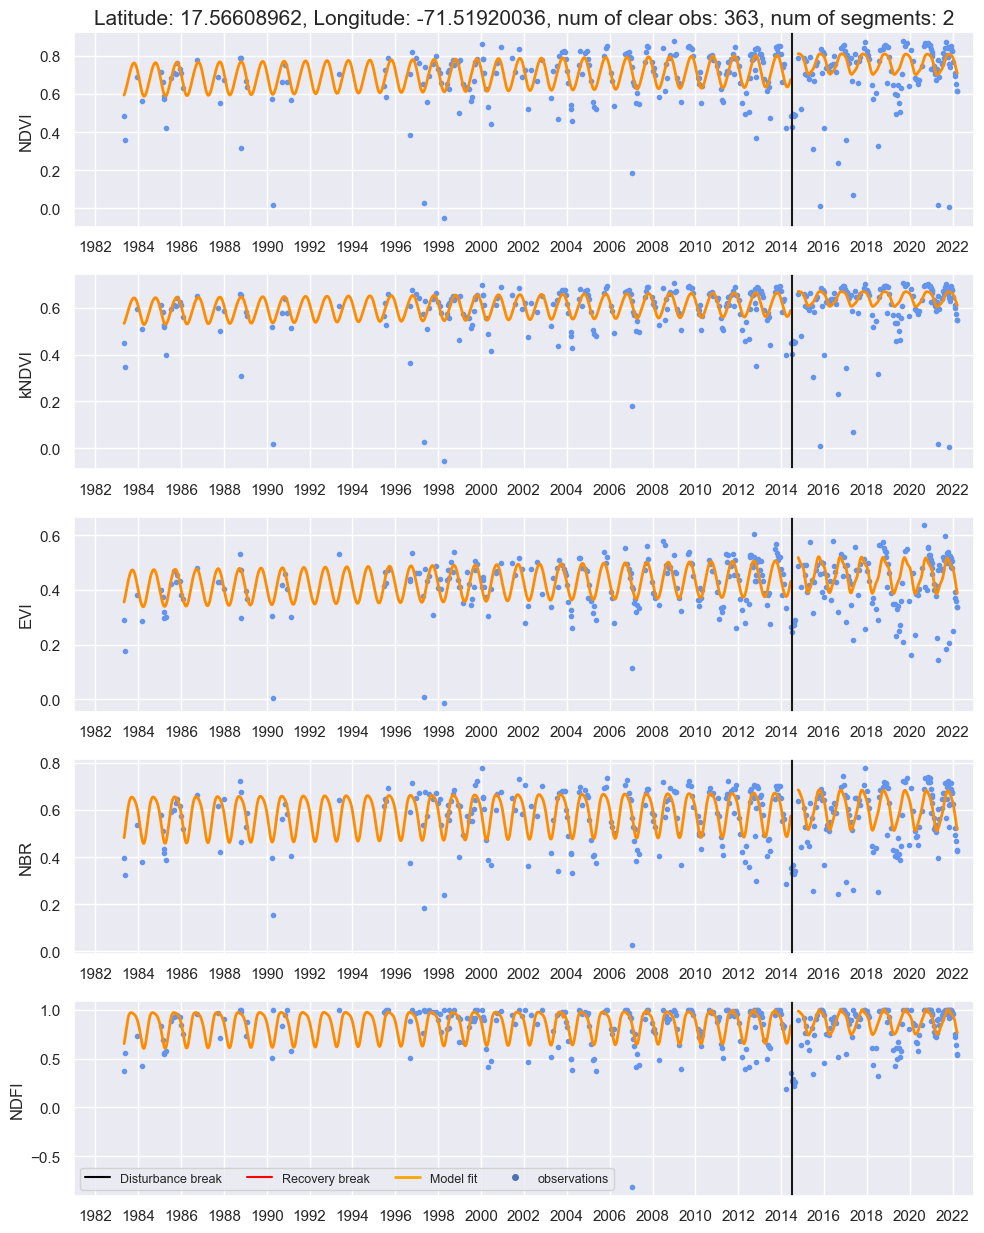

19.02904 -70.97137591 h04v01 1172 2109


C:\Users\64937\AppData\Local\Temp\ipykernel_11012\4177704835.py:51: RuntimeWarning: divide by zero encountered in divide
  gv_shade = gv / (1 - shade)
C:\Users\64937\AppData\Local\Temp\ipykernel_11012\4177704835.py:52: RuntimeWarning: invalid value encountered in divide
  ndfi = (gv_shade - npv - soil) / (gv_shade + npv + soil)
C:\Users\64937\AppData\Local\Temp\ipykernel_11012\3283100843.py:276: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  x_axis_range = pd.date_range(datetime(year=1982, month=1, day=1), datetime(year=2024, month=1, day=1), freq='2Y')


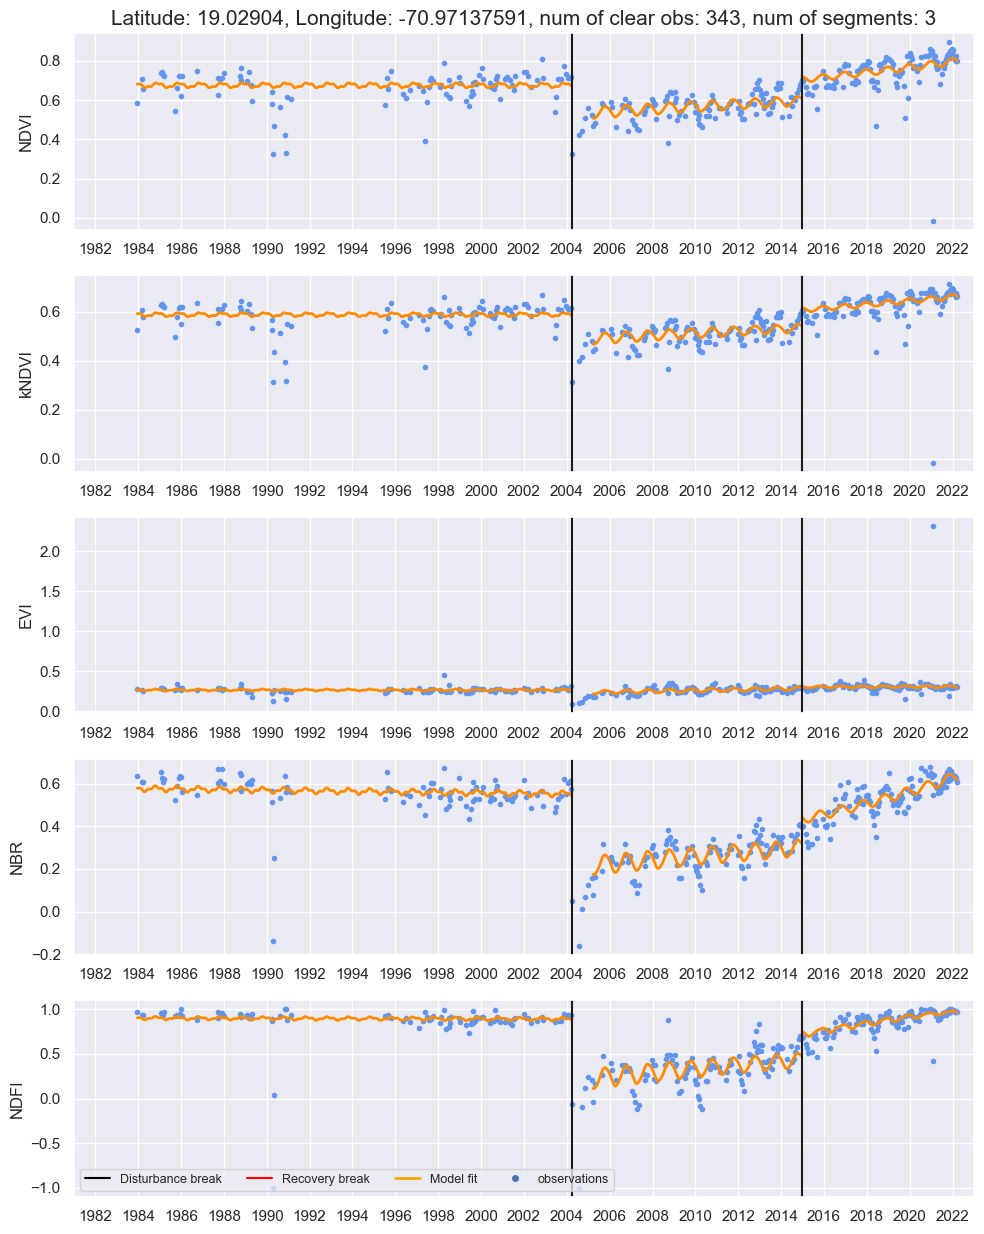

19.00814526 -71.18575332 h04v01 1446 1376


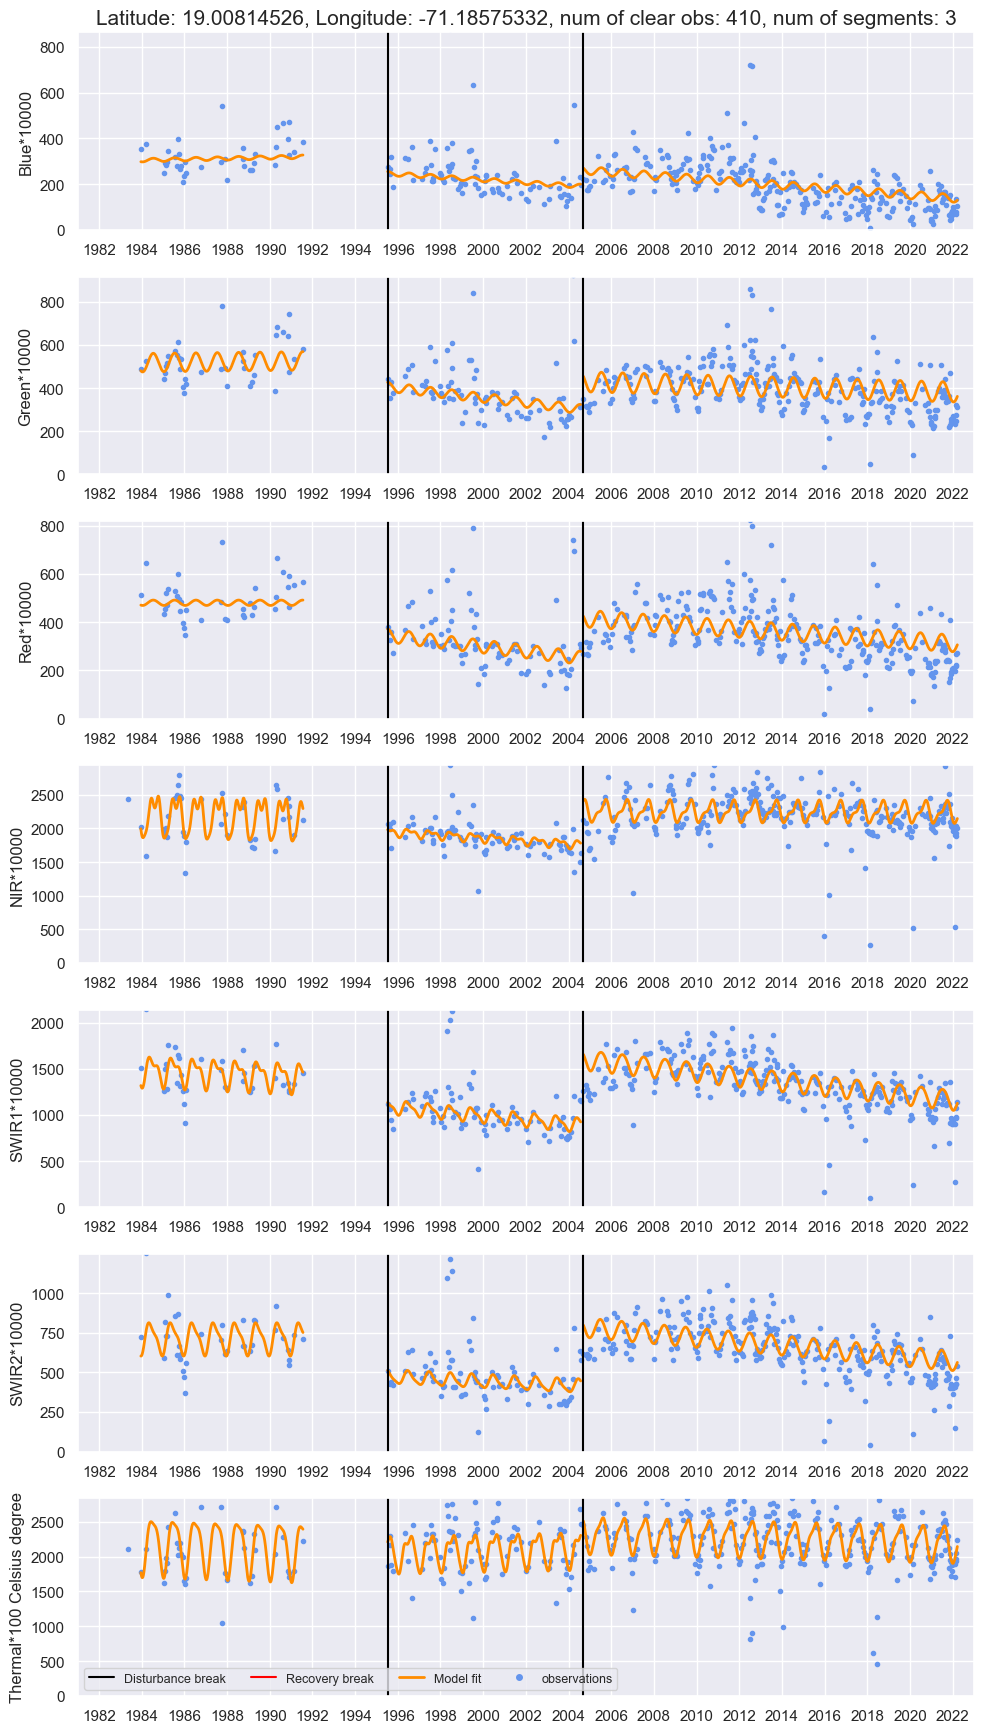

18.28849286 -71.34908449 h04v02 1573 1459


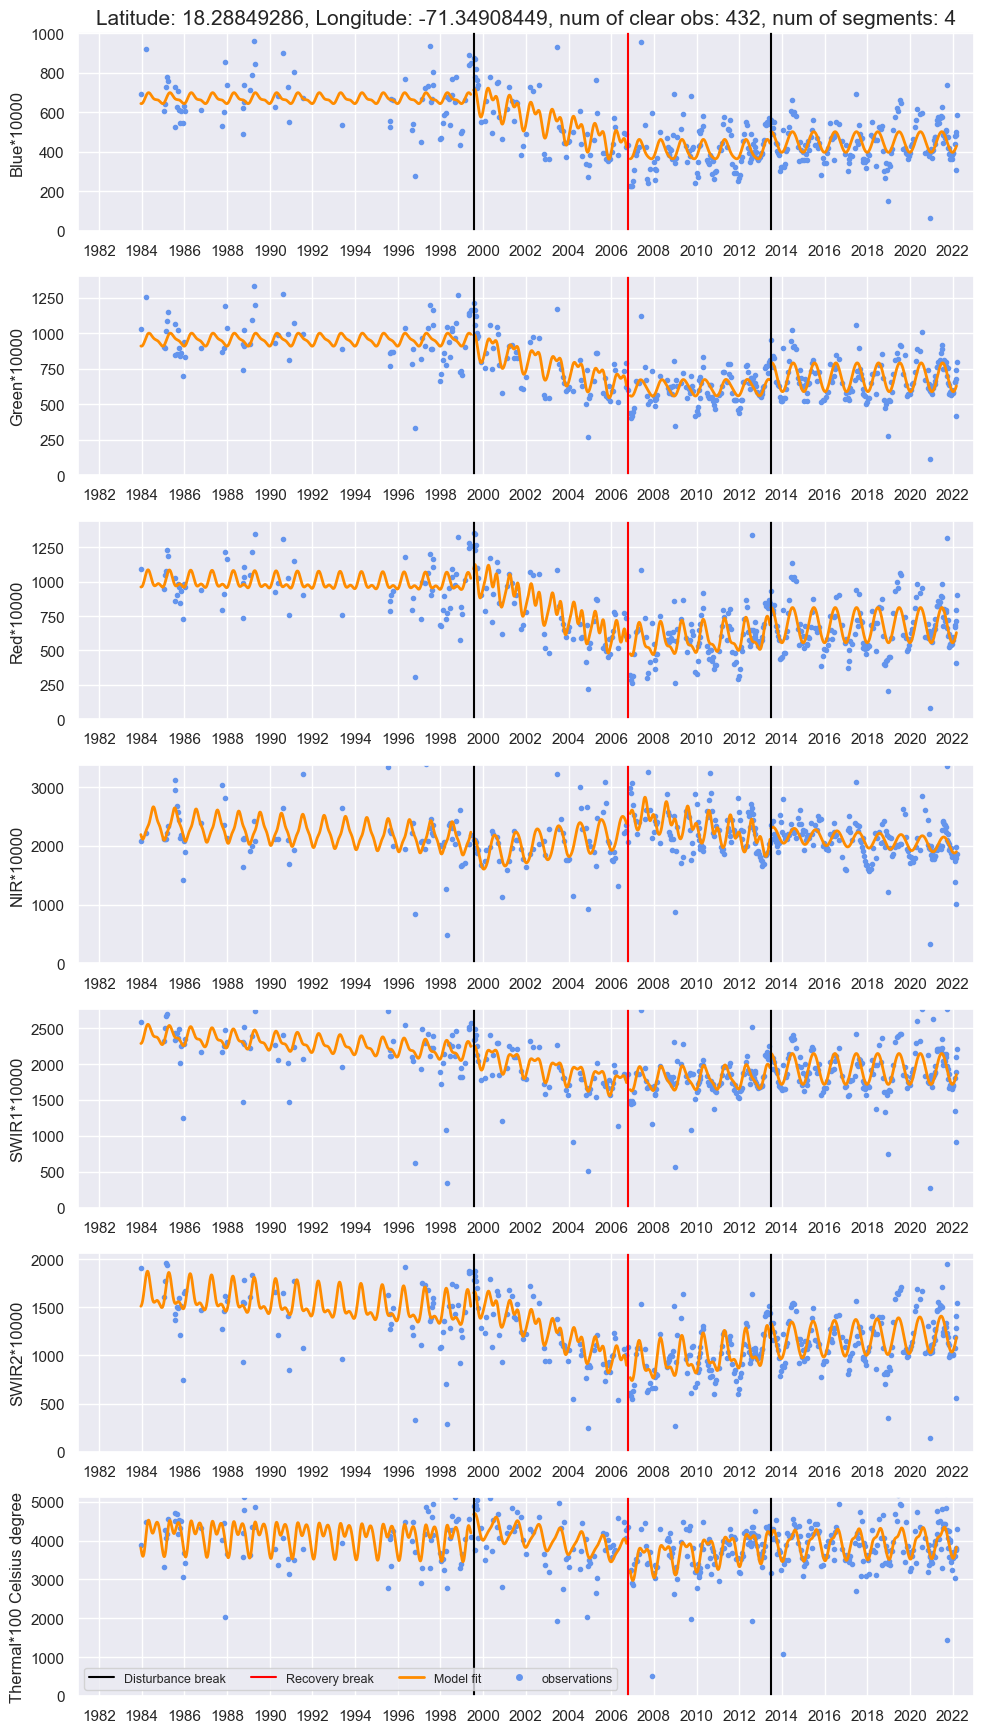

In [6]:
# def main():
# if __name__ == '__main__':

pwd = os.getcwd()
rootpath = os.path.abspath(os.path.join(pwd, '..'))
path_data = join(rootpath, 'data', 'post_processing_samples')

array_post_processing_example = np.array([[17.56608962, -71.51920036],  # Drought disturbance, delta_NBR < 0.05
                                          [19.02904, -70.97137591],  # Fire disturbance, delta_NBR > 0.05
                                          [19.00814526, -71.18575332],  # Correct the error in PF classification
                                          [18.28849286, -71.34908449],  # Correct the error in developed classification
                                          ])

for i in range(0, array_post_processing_example.shape[0]):

    latitude, longitude = array_post_processing_example[i, :]
    tilename, row_id_intile, col_id_intile = get_row_col_id_from_lat_long(latitude, longitude)
    print(latitude, longitude, tilename, row_id_intile, col_id_intile)

    filename_sample = join(path_data, '{}_row{}_col{}.csv'.format(tilename, row_id_intile, col_id_intile))
    df_plot = pd.read_csv(filename_sample)

    blues, greens, reds, nirs, swir1s, swir2s, thermals, qas = (df_plot['Blue'].values, df_plot['Green'].values,
                                                                df_plot['Red'].values, df_plot['NIR'].values,
                                                                df_plot['SWIR1'].values, df_plot['SWIR2'].values,
                                                                df_plot['Thermal'].values, df_plot['qa'].values)

    filename_cold_result = join(path_data, '{}_row{}_col{}_cold_result.npy'.format(tilename, row_id_intile, col_id_intile))
    cold_result_singlepixel = np.load(filename_cold_result, allow_pickle=True)

    num_clear_obs = np.count_nonzero(((qas == 0) | (qas == 1)))   # the number of clear observations
    title = f'Latitude: {latitude}, Longitude: {longitude}, num of clear obs: {num_clear_obs}, num of segments: {len(cold_result_singlepixel)}'

    if (i == 0) | (i == 1):
        ndvi, kndvi, nbr, evi, ndfi = vegetation_index_cal(blues, greens, reds, nirs, swir1s, swir2s)
        list_vegetation_index = ['NDVI', 'kNDVI', 'EVI', 'NBR', 'NDFI']
        plot_vegetation_index(df_plot, list_vegetation_index, ndvi, kndvi, evi, nbr, ndfi, cold_result_singlepixel, title,
                              cold_curve_plot_flag=True,)

    else:
        # list_band_name = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'Thermal']
        # list_band_name = ['Red', 'NIR', 'SWIR1']
        # list_band_name = ['NIR']
        list_band_name = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'Thermal']
        COLD_plot(df_plot, cold_result_singlepixel,
                  title=title, list_plot_band_name=list_band_name,
                  set_limit_flag=1, limit_pct=99, cold_curve_plot_flag=True,)
